# Investigating the Data Stream: Identifying Module Clusters

Our high-level goal is to come up with ways to raise awareness of high-quality learning modules. One preliminary building block for this goal is to identify module clusters, or groups of modules that have similar or complementary content.

[Previously](https://github.com/cwivagg/iiab_analytics/blob/main/notebooks/notebook20211222.md), we pulled some issue logs from the Internet-in-a-Box repository. The basic unit of data we isolated was the ```menu.json``` file submitted with some issue requests. Within the ```menu.json``` file is a list of the modules that the user submitting the issue has selected for their local copy of Internet-in-a-Box.

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

DATA_HOME = "../.." # Just a local directory where we put the previous notebook entry's data.

menus = []
with open(os.path.join(DATA_HOME, "menus.json")) as f:
    for line in f:
        menu = json.loads(line)["menu_items_1"]
        menus.append(menu)

print("Example menu:\n\n" + str(menus[0]))

Example menu:

['en-oob', 'en-sample', 'en-test_zim', 'en-test_mod', 'en-map_admin', 'en-osm_viewer_v2', 'en-usb', 'en-kalite', 'en-raspberrypi_stackexchange_com_en_all', 'en-wikiquote_en_all_nopic', 'en-wiktionary_en_all_nopic', 'en-wikipedia_en_all_nopic', 'en-musictheory', 'en-olpc', 'en-asst_medical', 'en-math_expression', 'en-rpi_guide', 'en-peacebuilding', 'en-understanding_algebra', 'en-scratch', 'en-wikem', 'en-ebooks', 'en-practical_action', 'en-siyavula', 'en-algebra2go', 'en-boundless', 'en-credits']


We'll focus on English modules for now, since most of the issues submitted have ```menu.json``` files containing exclusively English modules.

In [2]:
from collections import Counter

def count_languages(menu):
    languages = [module[:2] for module in menu]
    return Counter(languages)

def find_majority_language(menu):
    language_dict = count_languages(menu)
    return max(language_dict, key=language_dict.get)

english_menus = []
for menu in menus:
    if find_majority_language(menu) == "en":
        english_menus.append(menu)
print("Found {} English menus".format(len(english_menus)))

Found 18 English menus


To find module clusters, we'll make use of a paradigm from the recommendations field, the item-item matrix. An item-item matrix counts the number of times two modules are chosen by the same user. The underlying assumption is that a group, or cluster, of modules consistently chosen by the same group of users must be related in some way.

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

trunc = 3                                   # Just a constant to control how much we print out.

cts = CountVectorizer(analyzer=lambda x: x) # Usually, CountVectorizer is used to convert documents to bags of words.
                                            # Since our modules are already lists, we can skip this part.
X = cts.fit_transform(english_menus)
df = pd.DataFrame(X.toarray()[:trunc,:trunc],index=["menu 1", "menu 2", "menu 3"],columns=cts.get_feature_names_out()[:trunc])
print("X looks like:")
print(df)

Xc = (X.T * X).toarray()
Xc_labels = cts.get_feature_names_out()
df = pd.DataFrame(Xc[:trunc,:trunc],index=Xc_labels[:trunc],columns=Xc_labels[:trunc])
print("\n\nXc looks like:")
print(df)

X looks like:
        en-PhET  en-afristory  en-algebra2go
menu 1        0             0              1
menu 2        0             1              0
menu 3        0             0              0


Xc looks like:
               en-PhET  en-afristory  en-algebra2go
en-PhET              3             3              1
en-afristory         3             4              1
en-algebra2go        1             1              2


We can read this output like so: for the *i*th row and *j*th column, the matrix entry represents the number of times the *i*th and *j*th modules were selected together. So, en-PhET and en-algebra2go occurred in exactly one ```menu.json``` together, while en-PhET and en-afristory occurred in three ```menu.json``` lists together. The main diagonal is the number of times each module co-occurs with itself, or in other words, the total count of occurrences of that module. So en-PhET was selected three times, en-afristory four, and en-algebra2go two.

<AxesSubplot:>

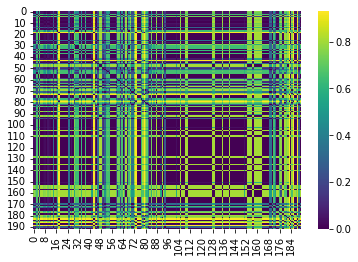

In [29]:
from scipy.spatial.distance import pdist, squareform

distance_matrix = squareform(pdist(Xc, metric="cosine")) # The pdist function will output a distance metric. We use
                                                         # cosine similarity, which aligns with the intuition we
                                                         # initially appealed to: we want similar things to be close
                                                         # together, or near one. The squareform function converts
                                                         # SciPy's standard pdist output to something a little more
                                                         # intuitive: a square  matrix where the ith row and jth
                                                         # column is the distance between the ith and jth row vectors
                                                         # in the pdist input.
sns.heatmap(distance_matrix, cmap="viridis")

Euclidean distance is a more standard choice than cosine similarity for this application, but in some earlier experimentation, we found that cosine similarity gave reasonable results and will help keep things intuitive.

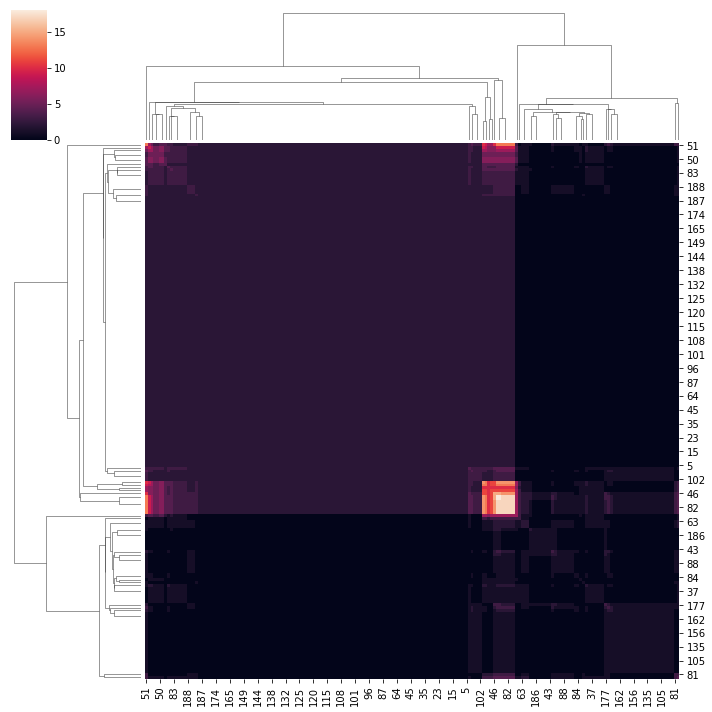

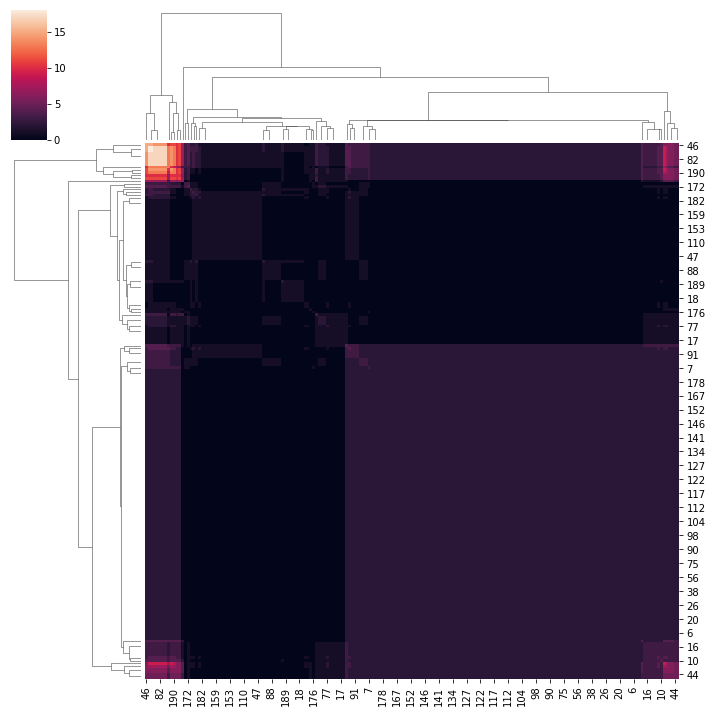

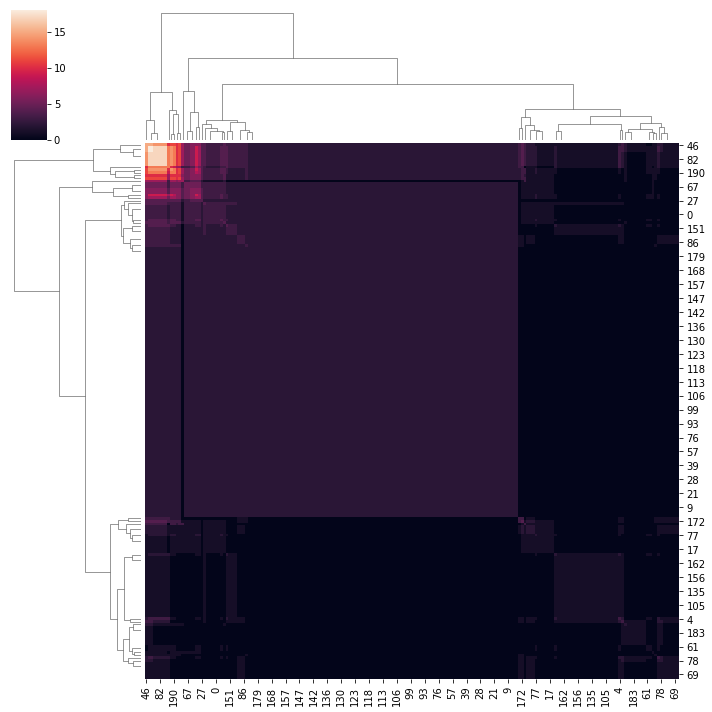

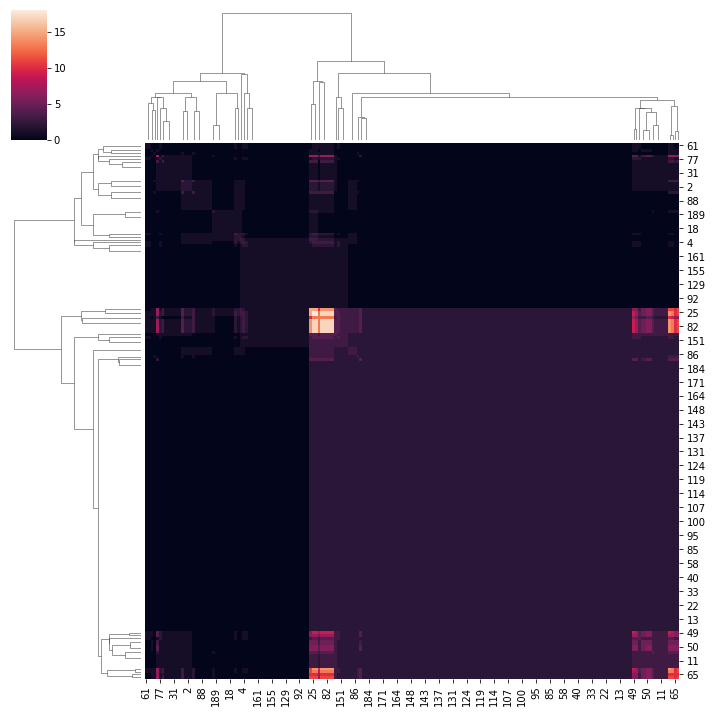

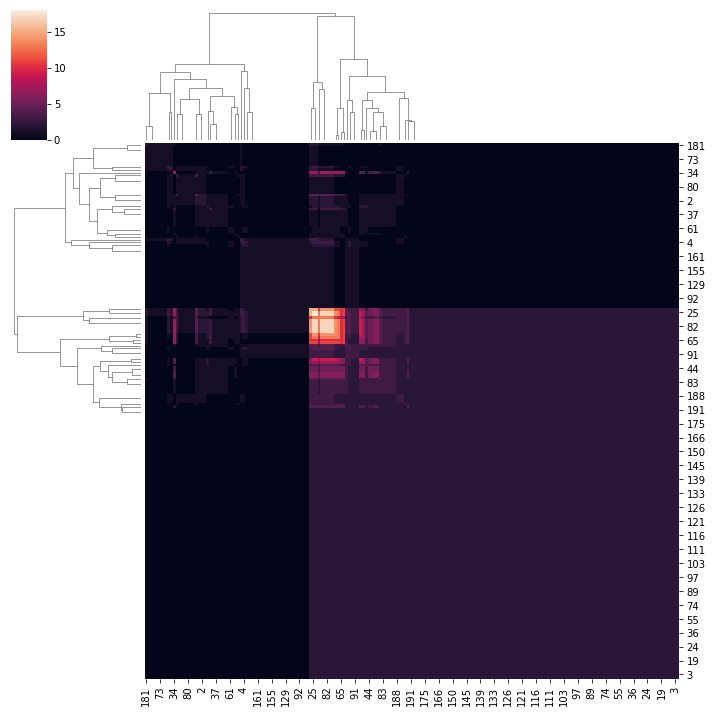

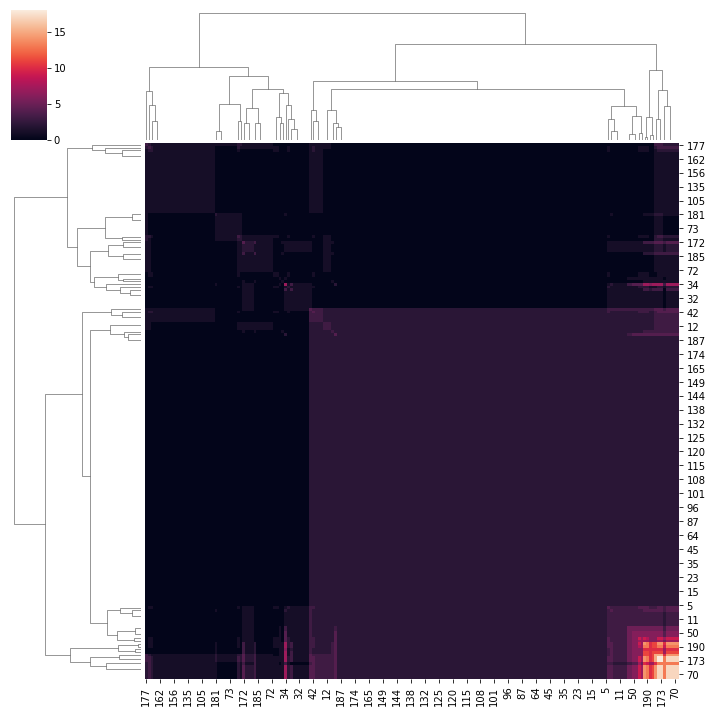

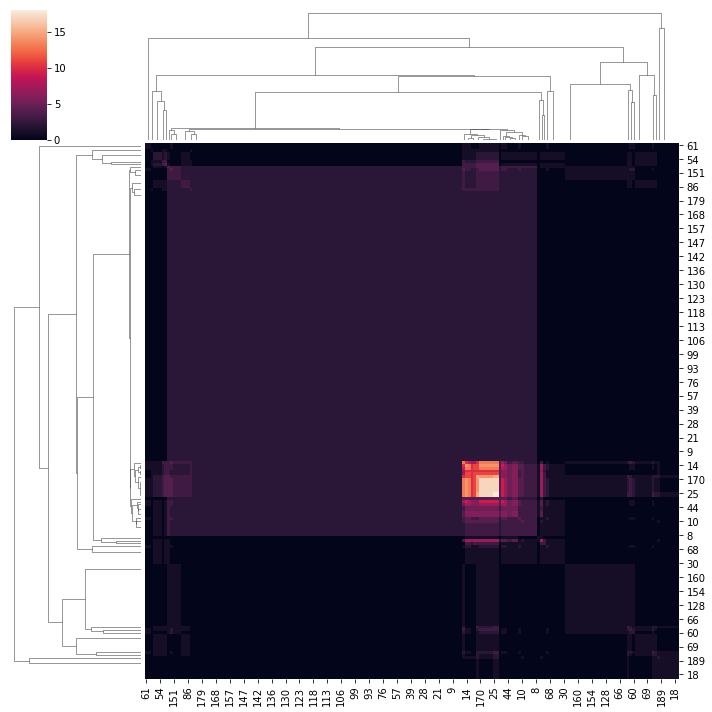

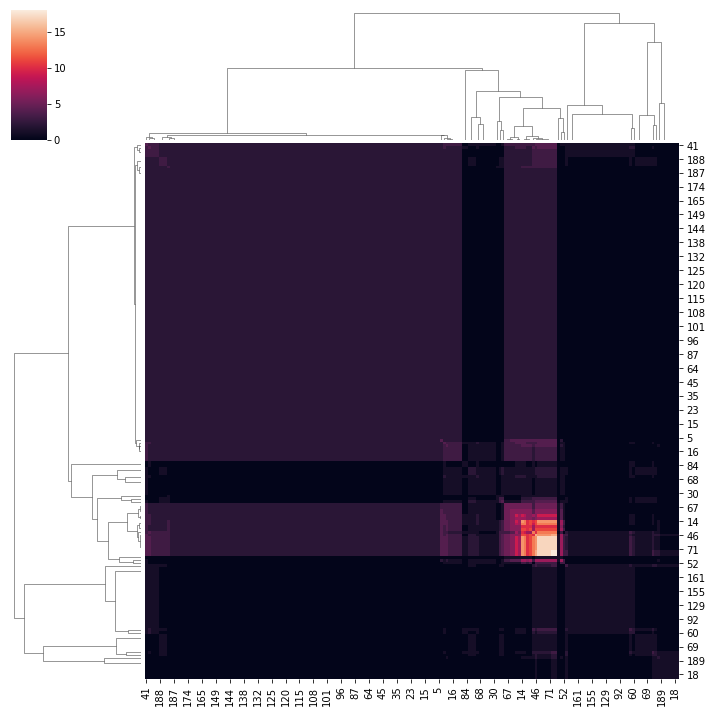

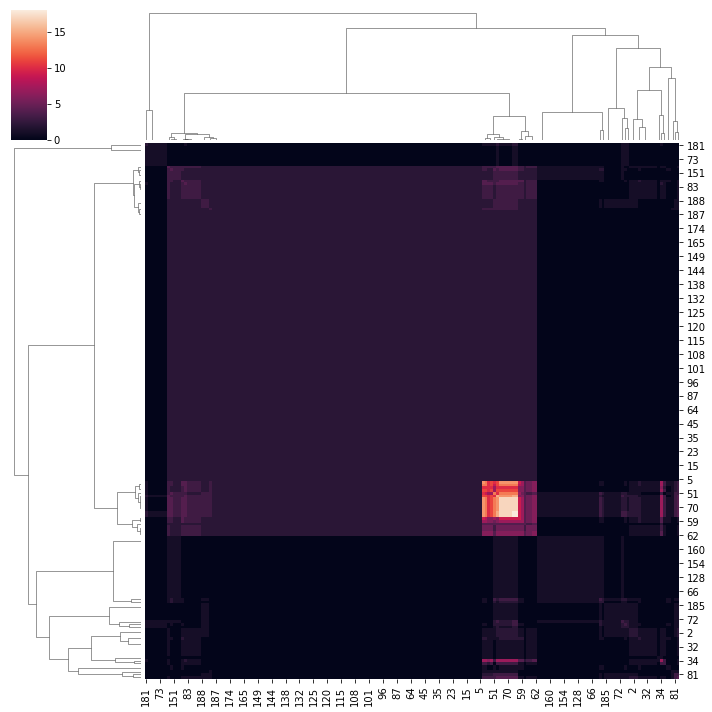

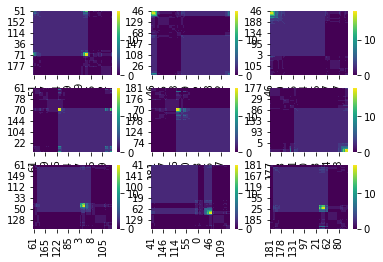

In [5]:
from scipy.cluster.hierarchy import linkage

heat_maps = []
linkages = []
for metric in candidate_metrics:
    data_for_metric = []
    linkage_for_metric = []
    for method in candidate_methods:
        d = pdist(Xc, metric=metric)
        l = linkage(Xc, metric=metric, method=method)
        data_for_metric.append(squareform(d))
        linkage_for_metric.append(sns.clustermap(Xc, row_linkage=l, col_linkage=l))
    heat_maps.append(data_for_metric)
    linkages.append(linkage_for_metric)


fig, ax = plt.subplots(len(heat_maps), len(heat_maps[0]))

for ix1, val2 in enumerate(candidate_metrics):
    for ix2, val2 in enumerate(candidate_methods):
        sns.heatmap(linkages[ix1][ix2].data2d, cmap="viridis", ax=ax[ix1][ix2])

In [6]:
ixes = [82]
print(Xc_labels[linkages[0][0].dendrogram_row.reordered_ind][105])

en-crafts_stackexchange_com_en_all


In [7]:
linkages[0][0].data2d.index.name

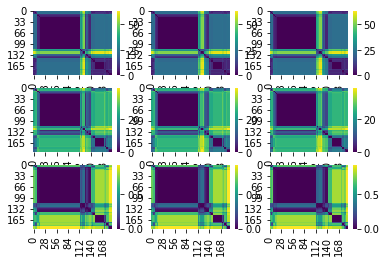

In [8]:
fig, ax = plt.subplots(len(heat_maps), len(heat_maps[0]))

row_ix = linkages[2][0].dendrogram_row.reordered_ind
col_ix = linkages[2][0].dendrogram_col.reordered_ind

for ix1, val2 in enumerate(candidate_metrics):
    for ix2, val2 in enumerate(candidate_methods):
        sns.heatmap(heat_maps[ix1][ix2][row_ix][:,col_ix], cmap="viridis", ax=ax[ix1][ix2])

In [9]:
from copy import deepcopy
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

thresh = 5

test_hm = deepcopy(distance_matrices[0])
zs = test_hm > thresh
os = test_hm <= thresh
test_hm[zs] = 0
test_hm[os] = 1
n_components, labels = connected_components(csgraph=csr_matrix(test_hm), directed=False)

In [10]:
components = []
for ix in range(n_components):
    component = Xc_labels[labels==ix]
    components.append(component)

<AxesSubplot:>

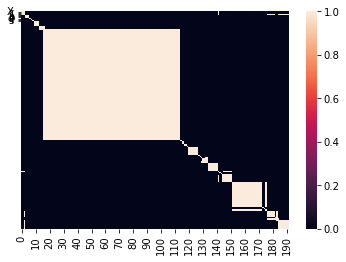

In [11]:
sns.heatmap(test_hm[row_ix][:,col_ix],xticklabels=10, yticklabels='Xc_labels')
#plt.savefig("seaborn.png",dpi=10000)

In [12]:
def get_cluster_average_count(list_of_labels):
    Xc_labels_list = list(Xc_labels)
    s = 0
    for label in list_of_labels:
        ix = Xc_labels_list.index(label)
        s += Xc[ix,ix]
    return s / len(list_of_labels)

In [13]:
components.sort(key = lambda x: get_cluster_average_count(x))
for component in components[-15:]:
    print("{:.1f} - {}".format(get_cluster_average_count(component), component))

3.0 - ['en-rpi_guide']
3.0 - ['en-wikem']
3.2 - ['en-hesperian_health' 'en-stanford_em'
 'en-ted_en_playlist-10-ideas-for-ending-hiv-aids'
 'en-ted_en_playlist-how-your-brain-constructs-real']
3.3 - ['en-PhET' 'en-afristory' 'en-binofino' 'en-blockly-games' 'en-bookdash'
 'en-catdogbooks' 'en-saylor']
4.0 - ['en-cups']
4.0 - ['en-healthphone']
4.0 - ['en-understanding_algebra']
5.8 - ['en-internetarchive' 'en-lokole' 'en-mediawiki' 'en-moodle' 'en-nodered']
7.0 - ['en-elgg']
9.0 - ['en-kolibri']
10.5 - ['en-nextcloud' 'en-sugarizer']
13.0 - ['en-map_admin']
13.5 - ['en-calibreweb' 'en-wordpress']
15.0 - ['en-kalite']
17.3 - ['en-credits' 'en-oob' 'en-osm_viewer_v2' 'en-sample' 'en-test_mod'
 'en-test_zim' 'en-usb']


In [14]:
ct_sums = np.sum(X.toarray(),axis=0)
topK = 20
for ix, ele in enumerate([(x, y) for y, x in sorted(zip(ct_sums, Xc_labels))][-topK:]):
    print("{} - {}".format(topK-ix, ele))

20 - ('en-internetarchive', 5)
19 - ('en-nodered', 5)
18 - ('en-lokole', 6)
17 - ('en-moodle', 6)
16 - ('en-elgg', 7)
15 - ('en-mediawiki', 7)
14 - ('en-kolibri', 9)
13 - ('en-nextcloud', 10)
12 - ('en-sugarizer', 11)
11 - ('en-map_admin', 13)
10 - ('en-wordpress', 13)
9 - ('en-calibreweb', 14)
8 - ('en-kalite', 15)
7 - ('en-oob', 17)
6 - ('en-osm_viewer_v2', 17)
5 - ('en-sample', 17)
4 - ('en-test_mod', 17)
3 - ('en-test_zim', 17)
2 - ('en-credits', 18)
1 - ('en-usb', 18)


In [15]:
S = ("S", 1)
M = ("M", 4)
L = ("L", 14)

def print_module_selection(module_selection_tuple):
    name, size = module_selection_tuple[0], module_selection_tuple[1]
    print("{} module grouping:\n".format(name))
    modules = []
    for module_cluster in components[-size:]:
        modules += list(module_cluster)
    for module in modules:
        print(module)

In [16]:
print_module_selection(L)

L module grouping:

en-wikem
en-hesperian_health
en-stanford_em
en-ted_en_playlist-10-ideas-for-ending-hiv-aids
en-ted_en_playlist-how-your-brain-constructs-real
en-PhET
en-afristory
en-binofino
en-blockly-games
en-bookdash
en-catdogbooks
en-saylor
en-cups
en-healthphone
en-understanding_algebra
en-internetarchive
en-lokole
en-mediawiki
en-moodle
en-nodered
en-elgg
en-kolibri
en-nextcloud
en-sugarizer
en-map_admin
en-calibreweb
en-wordpress
en-kalite
en-credits
en-oob
en-osm_viewer_v2
en-sample
en-test_mod
en-test_zim
en-usb
